# Package loading

In [17]:
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization, Activation, add, concatenate

# Datasets Manipulations

In [4]:
import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

In [1]:
!pwd

/home/tao/treecrown_delineation/treenet/tensorflow


In [14]:
raster_path = '../../tiles/tile_WV3_Pansharpen_11_2016_25.tif'
mask_path = '../../masks/mask_25.tif'

In [18]:
def get_raster(raster_path):
    ds = gdal.Open(raster_path)
    arr = np.empty((ds.RasterYSize, ds.RasterXSize, ds.RasterCount))
    for b in range(1, ds.RasterCount + 1):
        band = ds.GetRasterBand(b).ReadAsArray()
        arr[:, :, b-1] = band
    return arr

In [19]:
def norma_data(data, norma_methods="z-score"):
    arr = np.empty(data.shape)
    for i in range(data.shape[-1]):
        array = data.transpose(2, 0, 1)[i, :, :]
        mins, maxs, mean, std= np.percentile(array, 1), np.percentile(array, 99), np.mean(array), np.std(array)
        if norma_methods == "z-score":
            new_array = (array-mean)/std
        else:
            new_array = np.clip(2*(array-mins)/(maxs-mins), 0, 1)
        arr[:, :, i] = new_array
    return arr

In [15]:
arr = get_raster(mask_path)
arr = norma_data(arr, norma_methods='min-max')

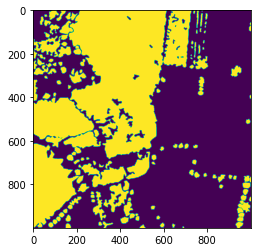

In [16]:
plt.imshow(arr[:, :, :])
plt.show()

In [ ]:
def treedatatset(raster_path, mask_path):
    
    raster = get_raster(raster_path)
    raster_norma = norma_data(raster, norma_methods='min-max')
    mask = get_raster(mask_path)
    
    dataset = tf.data.Dataset.from_slices((x, y))

# Model Construction

In [4]:
def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path

In [5]:
def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder

In [6]:
def decoder(x, from_encoder):
    main_path = UpSampling2D(size=(2, 2))(x)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [256, 256], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    return main_path

In [7]:
def build_res_unet(input_shape):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [512, 512], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path)

    return Model(inputs=inputs, outputs=path)

In [9]:
input_shape = (512, 512, 8)

In [10]:
model = build_res_unet(input_shape=input_shape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 8) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 64) 4672        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 64) 576         input_1[0][0]                    
______________________________________________________________________________________________

# Model Compile

In [12]:
# Optimizer, Loss and metrics

# Model Training